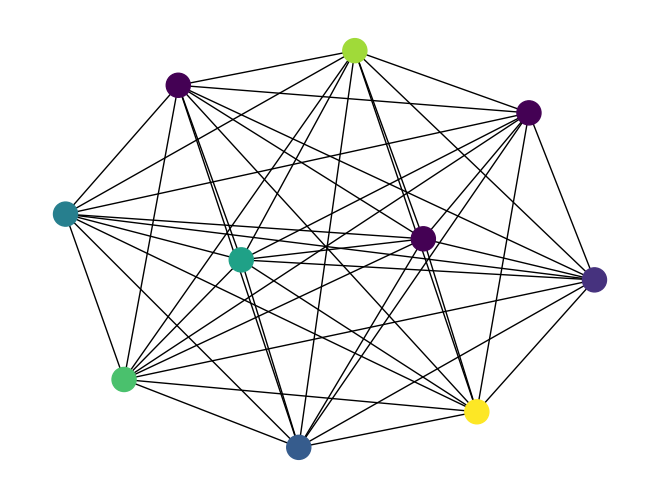

In [232]:
import networkx as nx
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import numpy as np
import heapq




from itertools import product

def basic_alg(graph, threshold=2):
    # Initialize all nodes with the same color (e.g., color 0)
    colors = defaultdict(lambda: 0)

    # Create a defect number map for nodes
    defect_map = {node: len(list(graph.neighbors(node))) for node in graph.nodes()}

    # Initialize variable for the max defect value
    max_defect = max(defect_map.values())

    # Continue until no node's defect number exceeds the threshold
    while max_defect > threshold:
        # Find the node with the highest defect number
        node = max(defect_map, key=defect_map.get)

        # Previous color of the node
        old_color = colors[node]

        # Recolor the node
        colors[node] += 1
        new_color = colors[node]

        # Adjust the defect number for the recolored node
        defect_map[node] = sum(1 for neighbor in graph.neighbors(node) if colors[neighbor] == new_color)

        # Adjust the defect number for the neighbors
        for neighbor in graph.neighbors(node):
            if colors[neighbor] == old_color:
                defect_map[neighbor] -= 1  # Decrease if the color was the same as the old color
            elif colors[neighbor] == new_color:
                defect_map[neighbor] += 1  # Increase if the color is the same as the new color

        # Recalculate the max defect value
        max_defect = max(defect_map.values())

    return dict(colors)  # Convert defaultdict back to regular dict for output









def get_smallest_available_color(bitmap):
    for i, available in enumerate(bitmap):
        if not available:
            return i
    return len(bitmap)

# Max-Defect Iterative Coloring (MDIC) algorithm
def MDIC(graph, threshold=2):
    colors = defaultdict(lambda: 0)
    bitmaps = {node: [False] * len(graph.nodes()) for node in graph.nodes()}
    defect_map = {node: len([neighbor for neighbor in graph.neighbors(node) if colors[neighbor] == colors[node]]) for node in graph.nodes()}
    max_defect = max(defect_map.values())

    while max_defect > threshold:
        node = max(defect_map, key=defect_map.get)
        old_color = colors[node]

        # Determine the new color based on the neighbor colors and bitmap
        for neighbor in graph.neighbors(node):
            bitmaps[node][colors[neighbor]] = True

        new_color = get_smallest_available_color(bitmaps[node])
        colors[node] = new_color

        # Update bitmap for the node and its neighbors
        bitmaps[node][new_color] = True
        for neighbor in graph.neighbors(node):
            bitmaps[neighbor][new_color] = True

            if colors[neighbor] == old_color:
                defect_map[neighbor] -= 1
            elif colors[neighbor] == new_color:
                defect_map[neighbor] += 1

        defect_map[node] = sum(1 for neighbor in graph.neighbors(node) if colors[neighbor] == new_color)
        max_defect = max(defect_map.values())

    return dict(colors)



from collections import defaultdict, Counter

def MDIC_V2(graph, threshold=2):
    colors = defaultdict(int)
    bitmaps = {node: [False] * len(graph.nodes()) for node in graph.nodes()}
    defect_map = {node: len([neighbor for neighbor in graph.neighbors(node) if colors[neighbor] == colors[node]]) for node in graph.nodes()}
    pq = [(defect, node) for node, defect in defect_map.items()]
    heapq.heapify(pq)
    visited = set()

    while pq:
        defect, node = heapq.heappop(pq)
        if defect <= threshold or node in visited:
            continue
        visited.add(node)

        old_color = colors[node]
        new_color = get_smallest_available_color(bitmaps[node])
        colors[node] = new_color

        # Update bitmap for the node and its neighbors
        bitmaps[node][new_color] = True
        for neighbor in graph.neighbors(node):
            bitmaps[neighbor][new_color] = True

            if colors[neighbor] == old_color or colors[neighbor] == new_color:
                # Update defect_map and priority queue for neighbor
                update_defects(neighbor, graph, colors, defect_map, pq)

        # Update defect_map and priority queue for node
        update_defects(node, graph, colors, defect_map, pq)

    return dict(colors)

def update_defects(node, graph, colors, defect_map, pq):
    new_defect = len([neighbor for neighbor in graph.neighbors(node) if colors[neighbor] == colors[node]])
    defect_map[node] = new_defect
    heapq.heappush(pq, (new_defect, node))








def KuhnDefectiveColoring(graph, threshold=2):
    """
    Improved version of the defective coloring algorithm.

    This function assigns colors to the nodes of a graph such that
    the maximum degree of the subgraph induced by any color is at most max_defect.

    :param graph: A NetworkX graph
    :param max_defect: Maximum allowed degree in color-induced subgraphs
    :return: Dictionary mapping each node to its color
    """
    colors = {}  # Dictionary to store the color assigned to each node
    color_subgraph_degrees = {}  # Tracks degree of each color's induced subgraph

    for node in graph.nodes():
        neighbor_colors = {colors.get(neighbor) for neighbor in graph.neighbors(node)}
        chosen_color = None

        # Try to find an existing color that can be used without exceeding the max_defect
        for color, max_degree in color_subgraph_degrees.items():
            if max_degree < threshold and color not in neighbor_colors:
                chosen_color = color
                break

        # If no existing color is suitable, assign a new color
        if chosen_color is None:
            chosen_color = len(color_subgraph_degrees) + 1
            color_subgraph_degrees[chosen_color] = 0

        # Assign the chosen color to the node
        colors[node] = chosen_color

        # Update degrees in color-induced subgraph
        for neighbor in graph.neighbors(node):
            if colors.get(neighbor) == chosen_color:
                color_subgraph_degrees[chosen_color] += 1

    return colors



# Example usage with 300 nodes and 1000 edges
G = nx.erdos_renyi_graph(10, 30)
threshold = 2
colors = MDIC(G, threshold)

# Color nodes based on computed coloring  
nx.draw(G, node_color=[colors[node] for node in G.nodes()])


In [233]:
def is_valid_coloring(graph, colors, threshold):
    """
    Check if the coloring is valid (no node has a defect number greater than the threshold).
    """
    for node in graph.nodes():
        defect = sum(1 for neighbor in graph.neighbors(node) if colors[neighbor] == colors[node])
        if defect > threshold:
            return False
    return True


Graph 10/10, Repetition 1/1
Benchmarking completed.
Results:
Graph Type	Algorithm	Execution Time	Num Colors
G200_D0.2	basic_alg	2.308856057168784	1.5714285714285714
G200_D0.2	KuhnDefectiveColoring	1.5932989690721648	1.5
G200_D0.2	MDIC	1.5247394980011797	1.5
G200_D0.3	basic_alg	4.19792139292196	2.0
G200_D0.3	KuhnDefectiveColoring	2.1662371134020617	1.9166666666666667
G200_D0.3	MDIC	2.3246608558883284	2.0
G200_D0.4	basic_alg	7.4329202586206895	2.4285714285714284
G200_D0.4	KuhnDefectiveColoring	3.4443298969072167	2.25
G200_D0.4	MDIC	3.356347073858051	2.8
G200_D0.5	basic_alg	10.704911524500908	3.0
G200_D0.5	KuhnDefectiveColoring	3.345446735395189	2.9166666666666665
G200_D0.5	MDIC	2.9792253751884132	3.4
G200_D0.6	basic_alg	12.52854185571688	3.5714285714285716
G200_D0.6	KuhnDefectiveColoring	3.8421821305841926	3.6666666666666665
G200_D0.6	MDIC	3.633298381283177	3.8
G200_D0.7	basic_alg	17.660517808529946	4.428571428571429
G200_D0.7	KuhnDefectiveColoring	4.629896907216495	4.25
G200_D0.7	MDIC	3

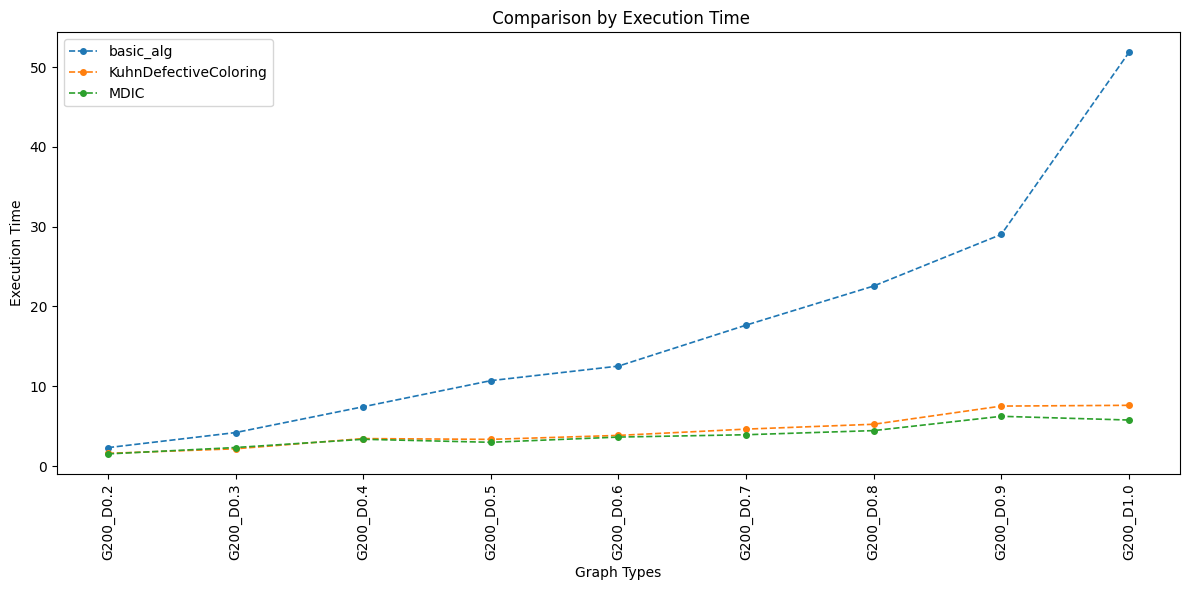

Slopes for execution_time:
  basic_alg: 5.164075497202055
  KuhnDefectiveColoring: 0.7500902061855669
  MDIC: 0.5304978482644123
Slope for basic_alg on num_colors: 0.8500000000000001
Slope for KuhnDefectiveColoring on num_colors: 1.3777777777777773
Slope for MDIC on num_colors: 1.6299999999999994


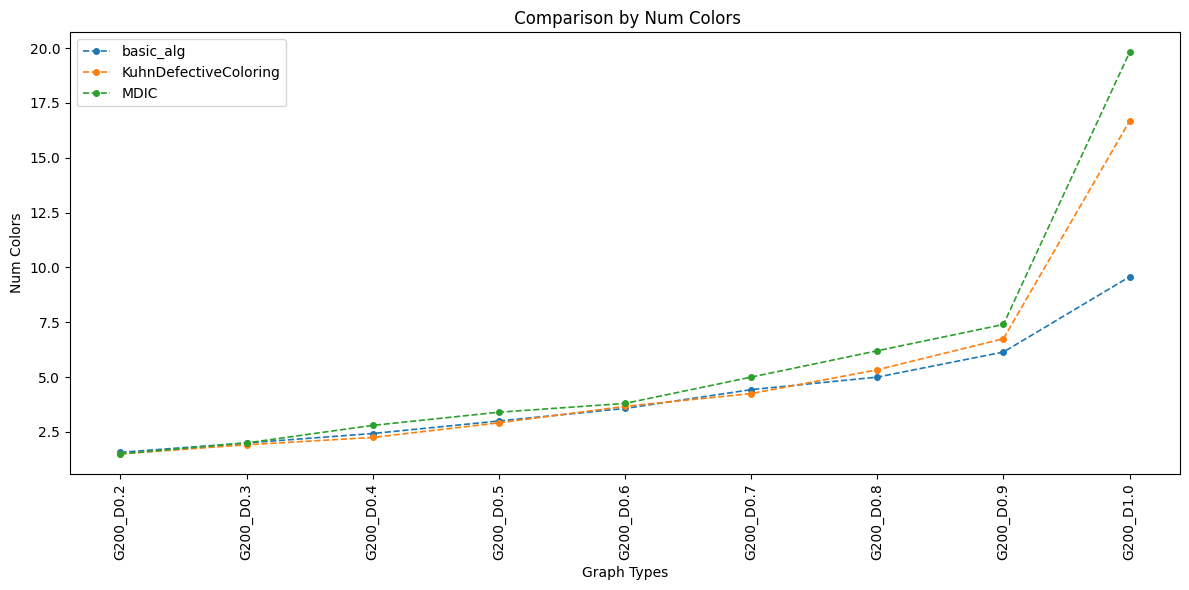

Slopes for num_colors:
  basic_alg: 0.8500000000000001
  KuhnDefectiveColoring: 1.3777777777777773
  MDIC: 1.6299999999999994
|   Density | Algorithm             |   Average Execution Time |   Average Number of Colors |
|----------:|:----------------------|-------------------------:|---------------------------:|
|       0.1 | basic_alg             |               0.0168152  |                          7 |
|       0.1 | KuhnDefectiveColoring |               0.00277519 |                         12 |
|       0.1 | MDIC                  |               0.00727606 |                         10 |
|       0.2 | basic_alg             |               0.0388238  |                         11 |
|       0.2 | KuhnDefectiveColoring |               0.00442171 |                         18 |
|       0.2 | MDIC                  |               0.0110941  |                         15 |
|       0.3 | basic_alg             |               0.0705888  |                         14 |
|       0.3 | KuhnDefectiveC

In [234]:
from tabulate import tabulate

# Enhanced graph generation
def generate_test_graphs():
    graphs = {}
    for nodes in [ 200]:
        for density in np.linspace(0.1, 1, 10):  # Varying densities from 0.1 to 1
            graph_name = f"G{nodes}_D{density:.1f}"
            graphs[graph_name] = nx.erdos_renyi_graph(nodes, density)
    return graphs

# Benchmarking function
def benchmark_coloring_algorithm(graph, algorithm):
    start_time = time.time()
    colors = algorithm(graph)
    end_time = time.time()
    num_colors = len(set(colors.values()))
    return end_time - start_time, num_colors

# Main benchmark execution
def main():
    graphs = generate_test_graphs()
    results = {}
    baseline = {}
    num_repetitions = 1  # Number of times each algorithm is tested

    total_graphs = len(graphs)
    total_algorithms = len([basic_alg, KuhnDefectiveColoring, MDIC])

    for graph_index, (graph_name, graph) in enumerate(graphs.items()):
        results[graph_name] = {}  # Initialize the dictionary for the current graph
        for algorithm_index, algorithm in enumerate([basic_alg, KuhnDefectiveColoring, MDIC]):
            total_exec_time = 0
            total_num_colors = 0
            for repetition in range(num_repetitions):
                print(f"Graph {graph_index + 1}/{total_graphs}, Repetition {repetition + 1}/{num_repetitions}\r", end="")
                exec_time, num_colors = benchmark_coloring_algorithm(graph, algorithm)
                total_exec_time += exec_time
                total_num_colors += num_colors
            
            avg_exec_time = total_exec_time / num_repetitions
            avg_num_colors = total_num_colors / num_repetitions

            results[graph_name][algorithm.__name__] = {
                "average_execution_time": avg_exec_time,
                "average_num_colors": avg_num_colors
            }


            # Calculate  factor compared to the baseline (smallest graph)
            if graph_name == "G200_D0.1":
                baseline[algorithm.__name__] = (avg_exec_time, avg_num_colors)
            else:
                exec_time = avg_exec_time / baseline[algorithm.__name__][0] if baseline[algorithm.__name__][0] > 0 else 0
                num_colors = avg_num_colors / baseline[algorithm.__name__][1] if baseline[algorithm.__name__][1] > 0 else 0
                results[graph_name][algorithm.__name__].update({
                    "execution_time": exec_time,
                    "num_colors": num_colors
                })

    print("\nBenchmarking completed.")
    return results



# Enhanced plotting function with line plot for execution time
def plot_results(benchmark_results):
    metrics = ['execution_time', 'num_colors']
    algorithms = ['basic_alg', 'KuhnDefectiveColoring', 'MDIC']
    graph_types = list(benchmark_results.keys())[1:]  # Exclude the baseline graph
    
    
    # print a table of the results
    print("Results:")
    print("Graph Type\tAlgorithm\tExecution Time\tNum Colors")
    for graph_type, algorithm in product(graph_types, algorithms):
        row = [graph_type, algorithm]
        for metric in metrics:
            row.append(benchmark_results[graph_type][algorithm][metric])
        print("\t".join(str(value) for value in row))
    
    

    for metric in metrics:
        plt.figure(figsize=(12, 6))
        slopes = {}

        # Collect values for each algorithm
        values = {alg: [benchmark_results[graph][alg].get(metric, 0) for graph in graph_types] for alg in algorithms}

        for alg in algorithms:
            
            plt.plot(graph_types, values[alg], label=f'{alg}', marker='o', linestyle='--', linewidth=1.2, markersize=4, alpha=1)
            # Calculate and log slope
            x = np.arange(len(graph_types))
            y = np.array(values[alg])
            slope = np.polyfit(x, y, 1)[0]  # Linear fit (degree 1), getting the slope
            slopes[alg] = slope
            print(f"Slope for {alg} on {metric}: {slope}")

        plt.xlabel('Graph Types')
        plt.ylabel(metric.replace('_', ' ').title())
        plt.title(f' Comparison by {metric.replace("_", " ").title()}')
        plt.legend()
        plt.xticks(rotation=90)  # Rotate x-axis labels vertically
        plt.tight_layout()
        plt.show()

        # Print slopes for each algorithm
        print(f"Slopes for {metric}:")
        for alg, slope in slopes.items():
            print(f"  {alg}: {slope}")



def tabulate_results(benchmark_results, graph_size):
    headers = ["Density", "Algorithm", "Average Execution Time", "Average Number of Colors"]
    table_data = []

    for density in np.linspace(0.1, 1, 10):
        graph_name = f"G{graph_size}_D{density:.1f}"
        for algorithm in benchmark_results[graph_name]:
            avg_exec_time = benchmark_results[graph_name][algorithm]["average_execution_time"]
            avg_num_colors = benchmark_results[graph_name][algorithm]["average_num_colors"]
            table_data.append([density, algorithm, avg_exec_time, avg_num_colors])

    return tabulate(table_data, headers=headers, tablefmt="pipe")
# Main execution
if __name__ == "__main__":
    benchmark_results = main()  # Ensure the main function is defined and returns benchmark_results

    plot_results(benchmark_results)
    print(tabulate_results(benchmark_results, 200))  # Example: Tabulate results for graphs with 50 vertices






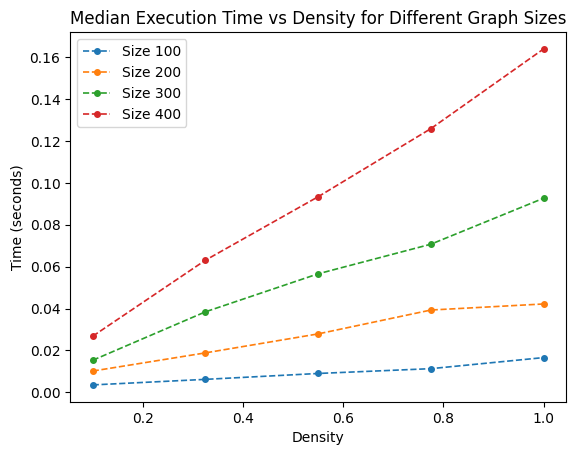

All tests passed.


True

In [244]:
def test_defective_coloring_with_timing():
    graph_sizes = [100,200,300,400]  # Range of graph sizes
    thresholds = range(1, 6)  # Range of thresholds
    densities = np.linspace(0.1, 1, 5)  # Range of densities
    num_tests = 2  # Number of tests per combination of graph size and threshold
    timing_results = {size: {density: [] for density in densities} for size in graph_sizes}

    for size in graph_sizes:
        for density in densities:
            times = []
            for _ in range(num_tests):
                graph = nx.erdos_renyi_graph(size, density)
                start_time = time.time()
                colors = MDIC(graph, 1)
                elapsed_time = time.time() - start_time

                if not is_valid_coloring(graph, colors, threshold):
                    print(f"Test failed for graph size {size} with density {density}")
                    return False


                times.append(elapsed_time)

            # Store the median time for this graph size and threshold
            timing_results[size][density] = np.median(times)

# Plotting with linear fits
    for size in graph_sizes:
        median_times = [timing_results[size][density] for density in densities]
        plt.plot(densities, median_times, label=f'Size {size}', marker='o', linestyle='--', linewidth=1.2, markersize=4, alpha=1)
        
        # Adding linear fit
        slope, intercept = np.polyfit(densities, median_times, 1)
        plt.plot(densities, slope*np.array(densities) + intercept, linestyle='-', alpha=0.7)

    plt.xlabel('Density')
    plt.ylabel('Time (seconds)')
    plt.title('Median Execution Time vs Density for Different Graph Sizes with Linear Fits')
    plt.legend()
    plt.show()

    print("All tests passed.")
    return True

# Run the test with timing
test_defective_coloring_with_timing()


In [236]:
# Create a sample graph
G = nx.erdos_renyi_graph(n=10, p=0.3)

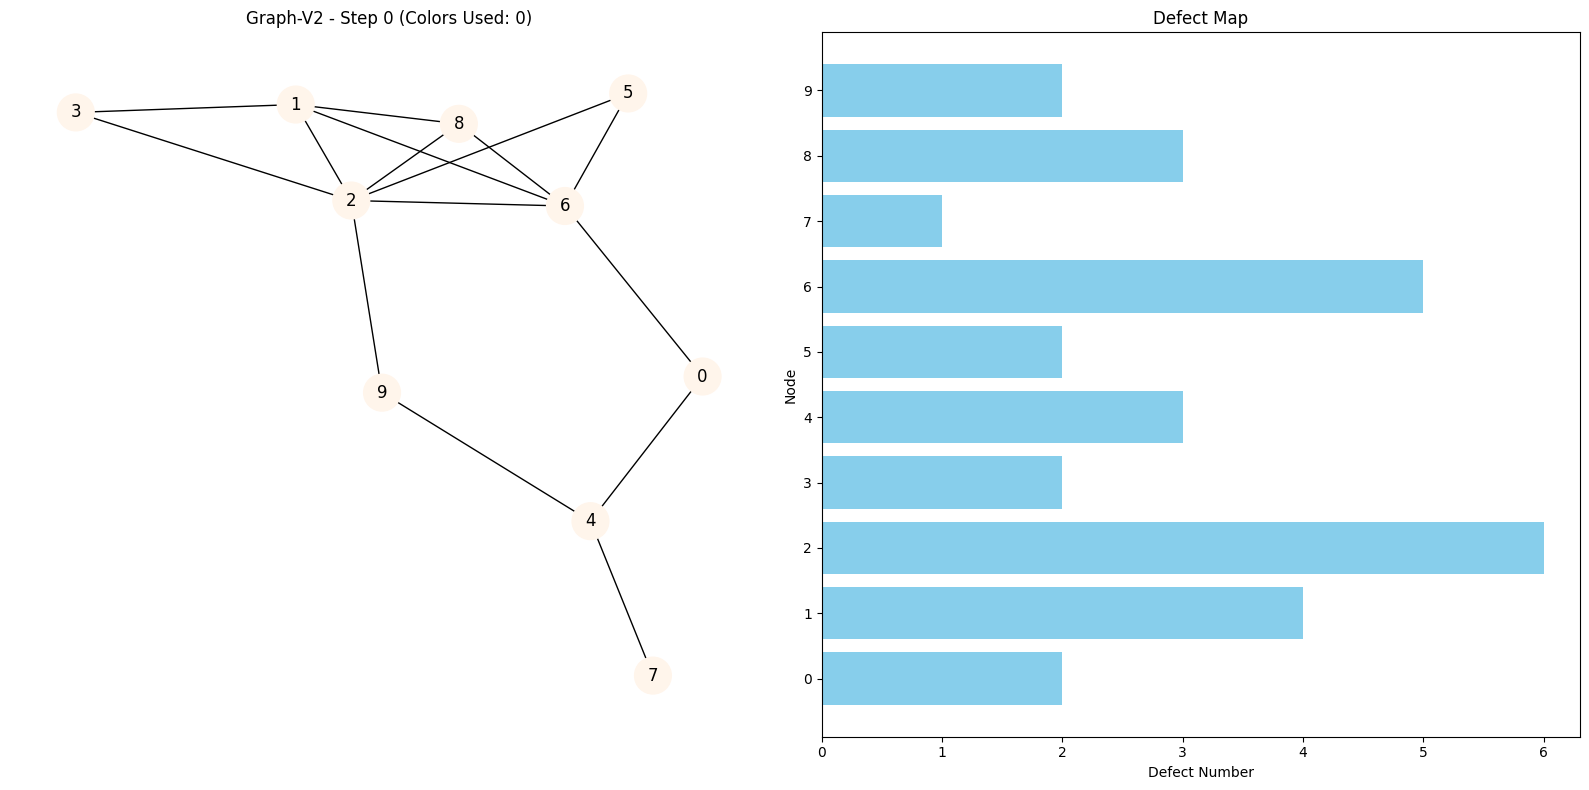

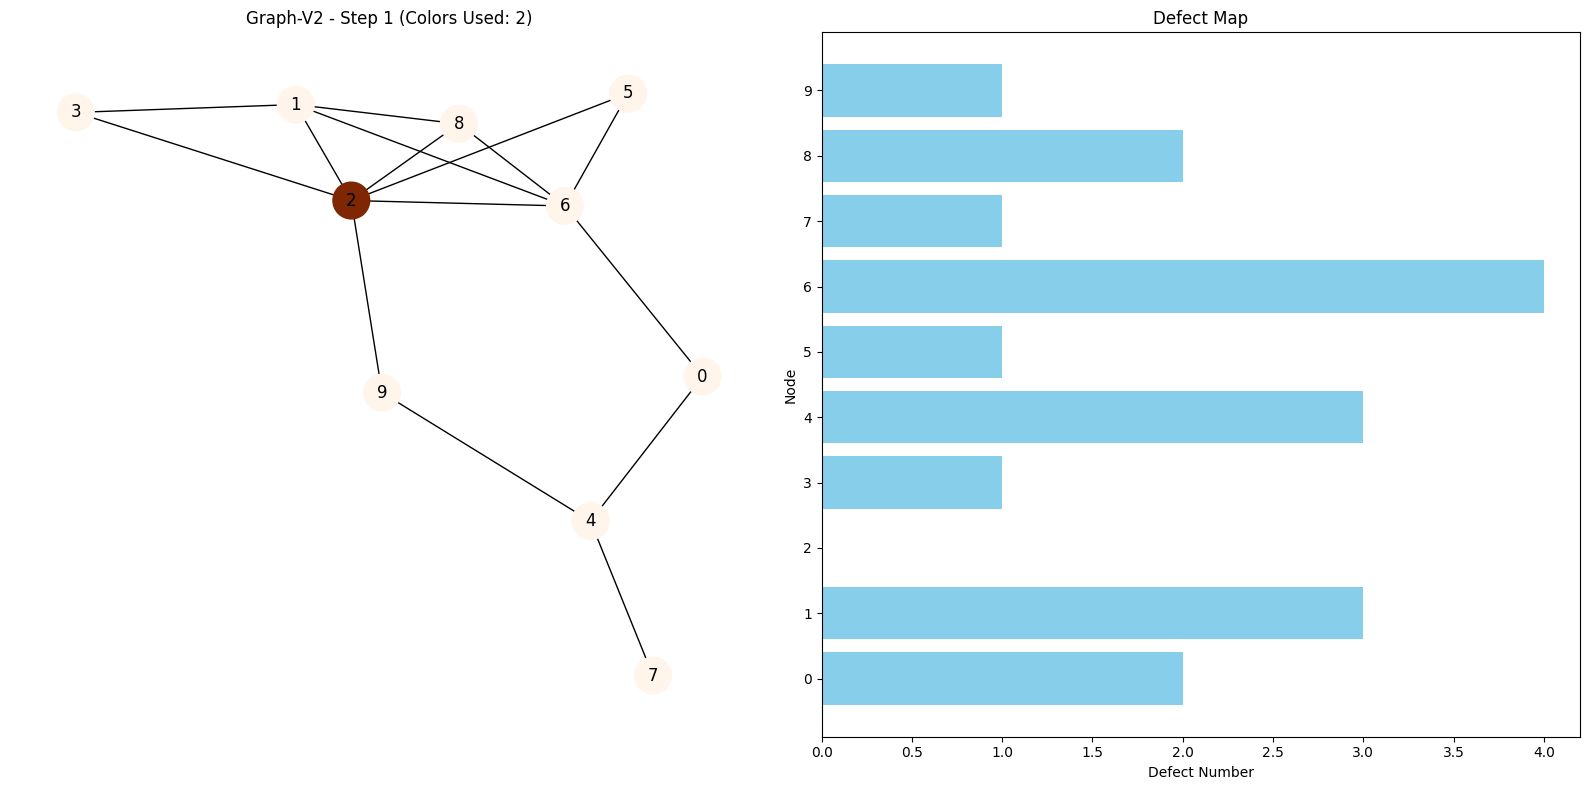

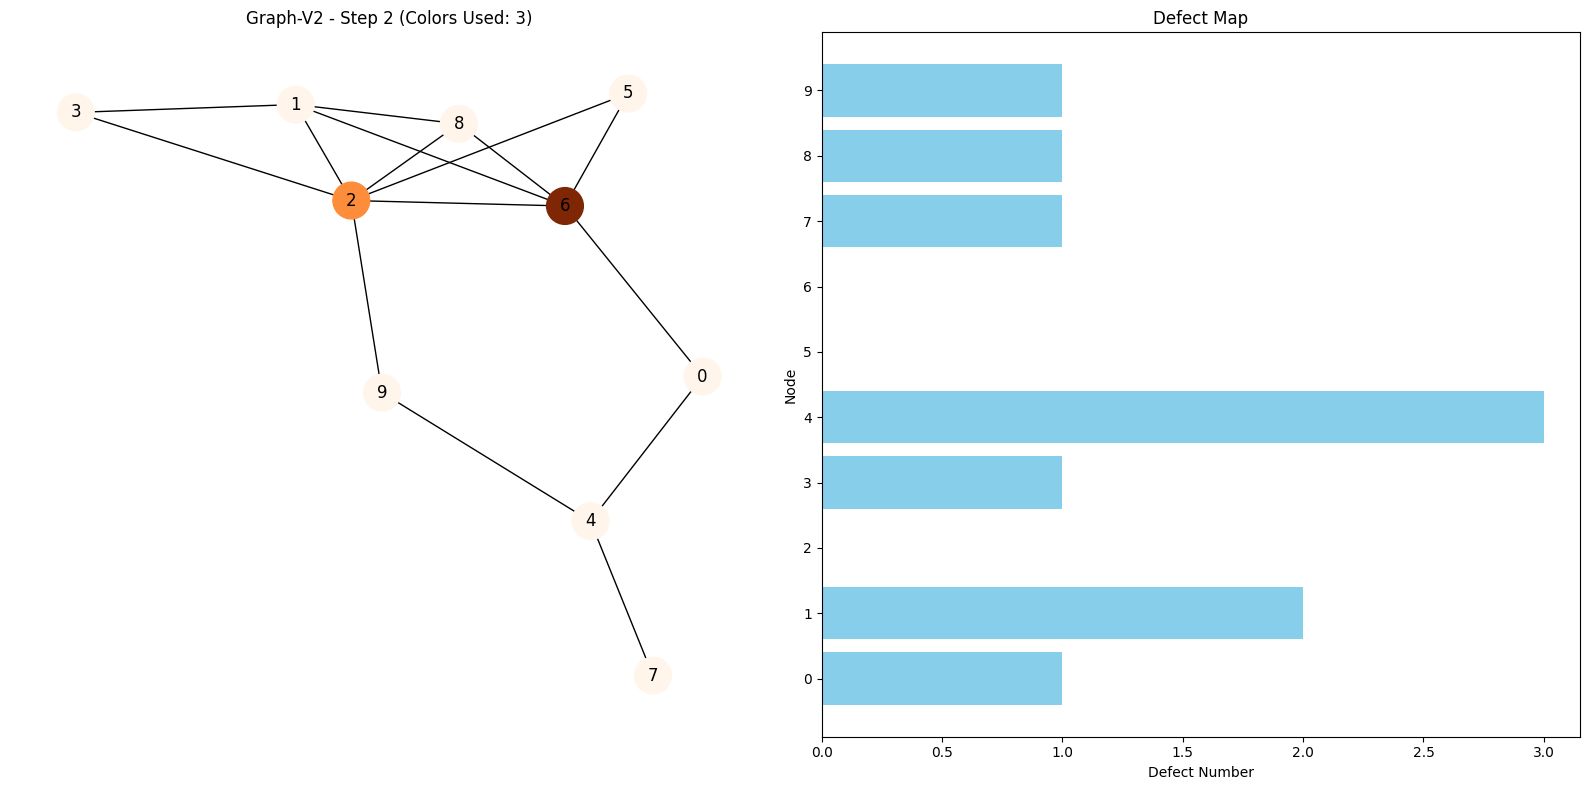

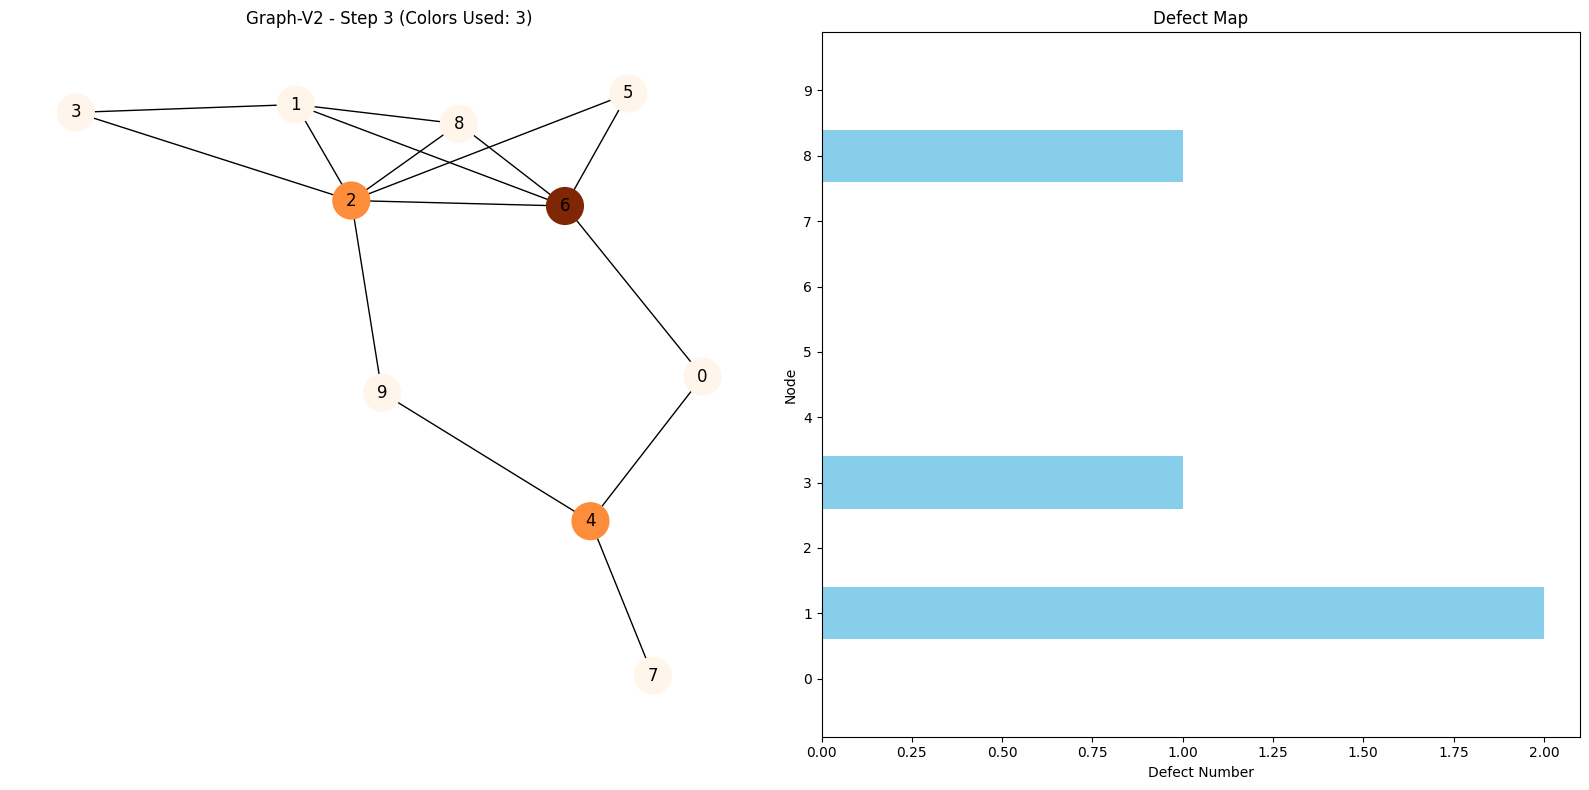

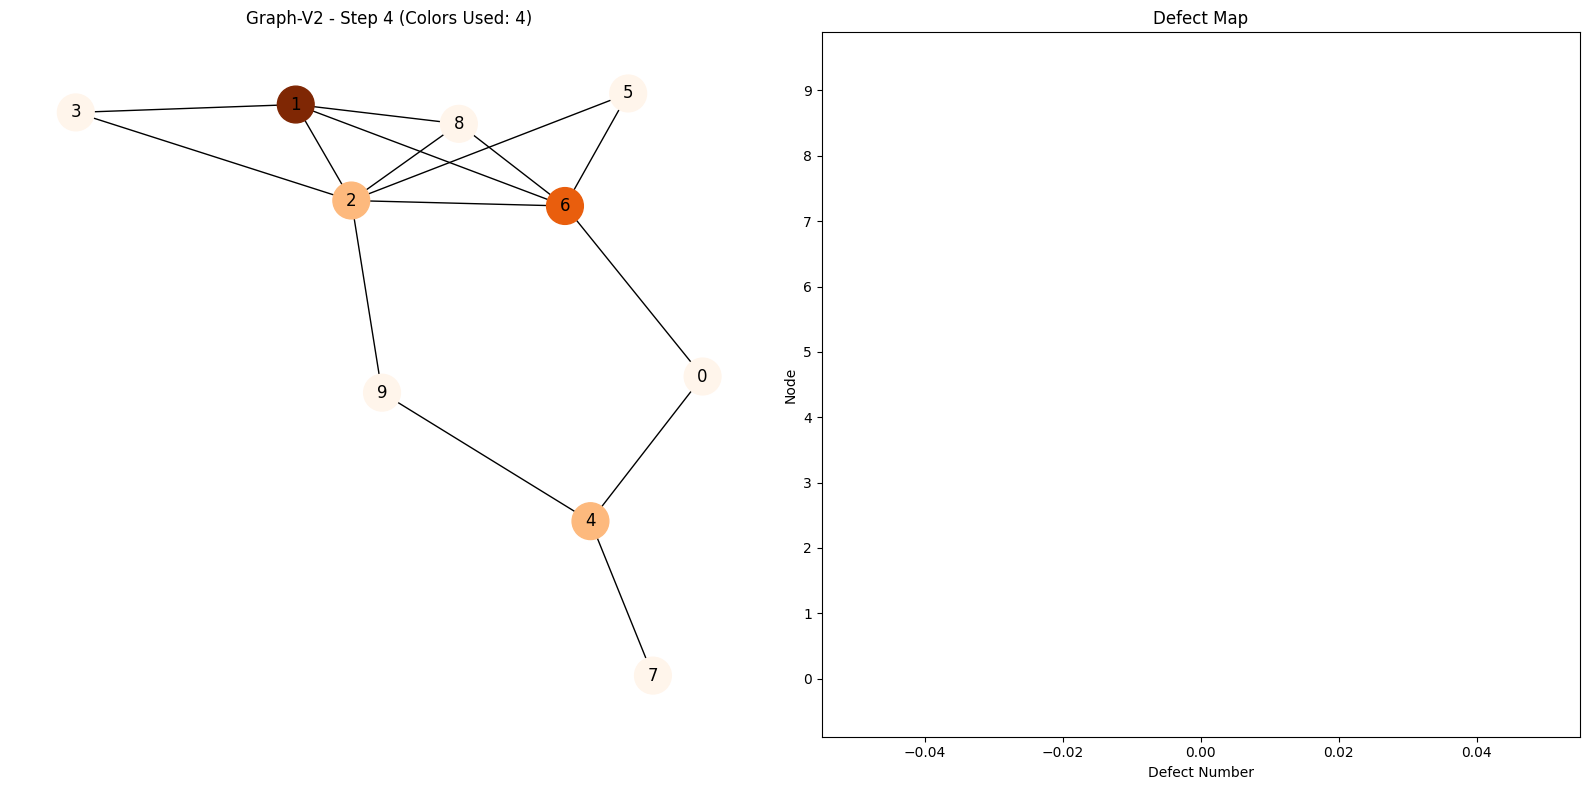

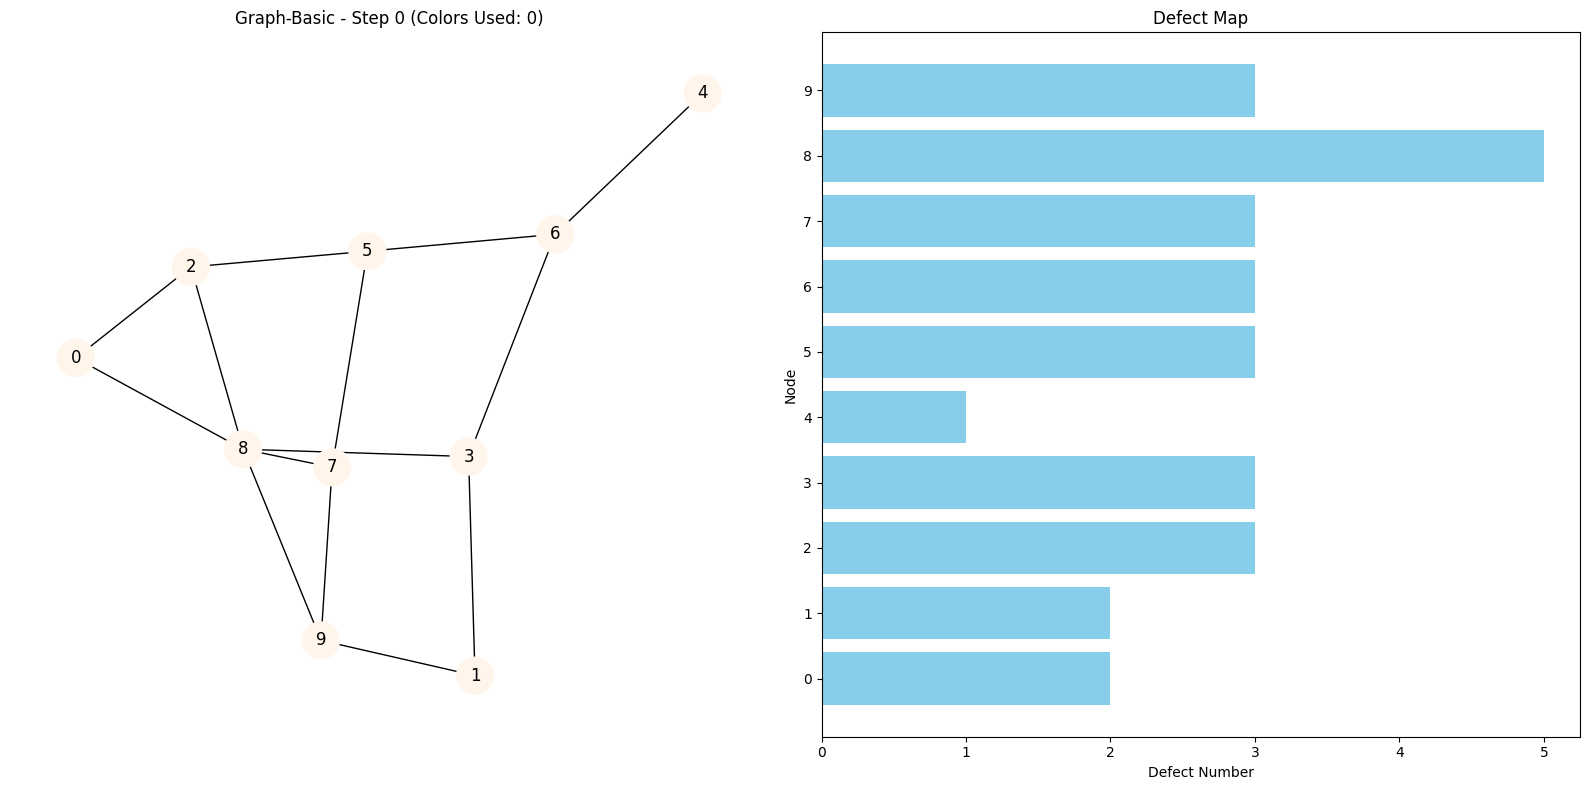

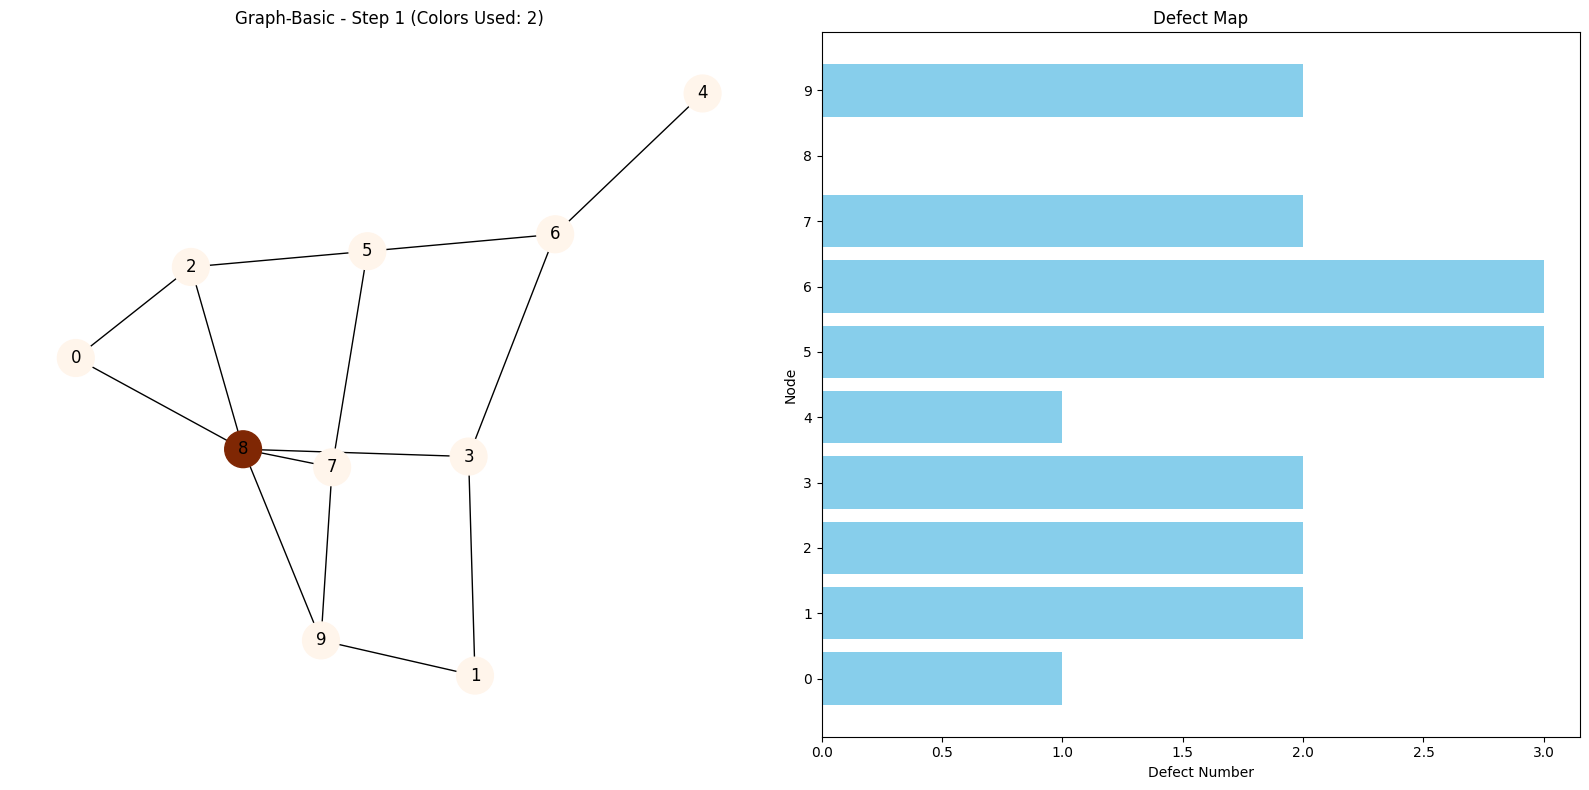

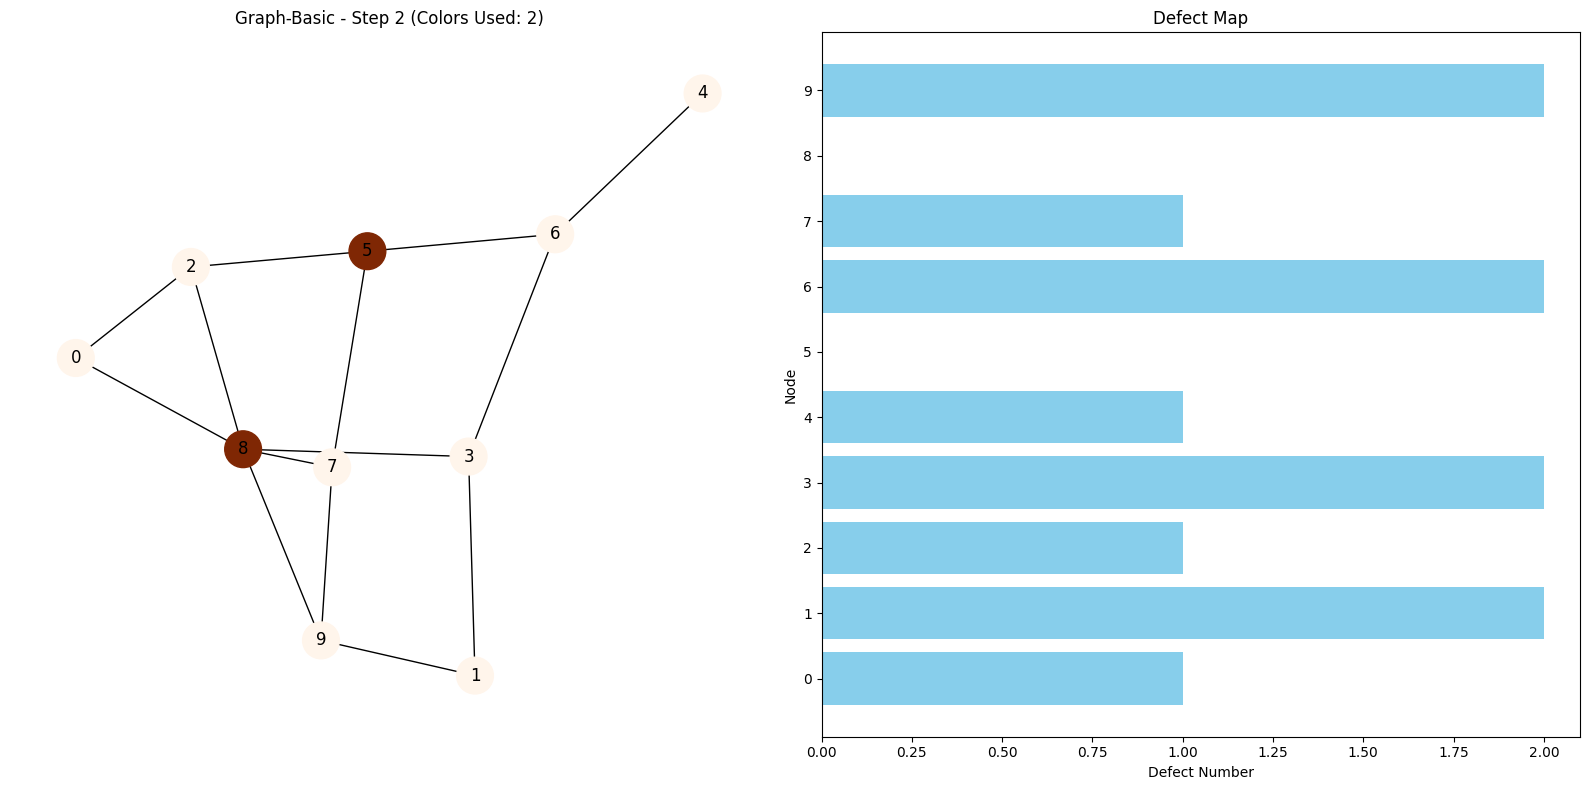

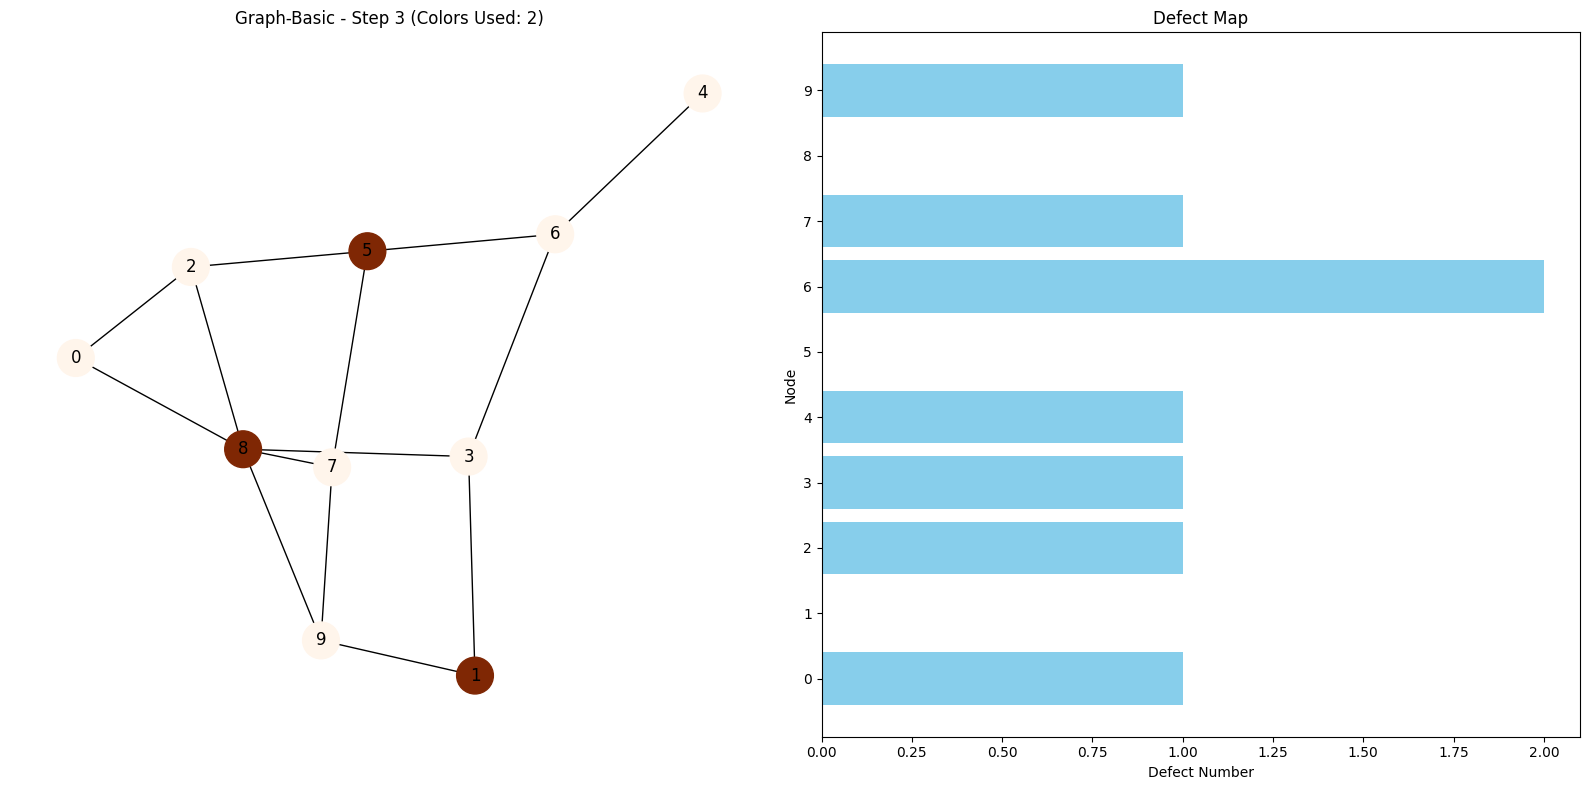

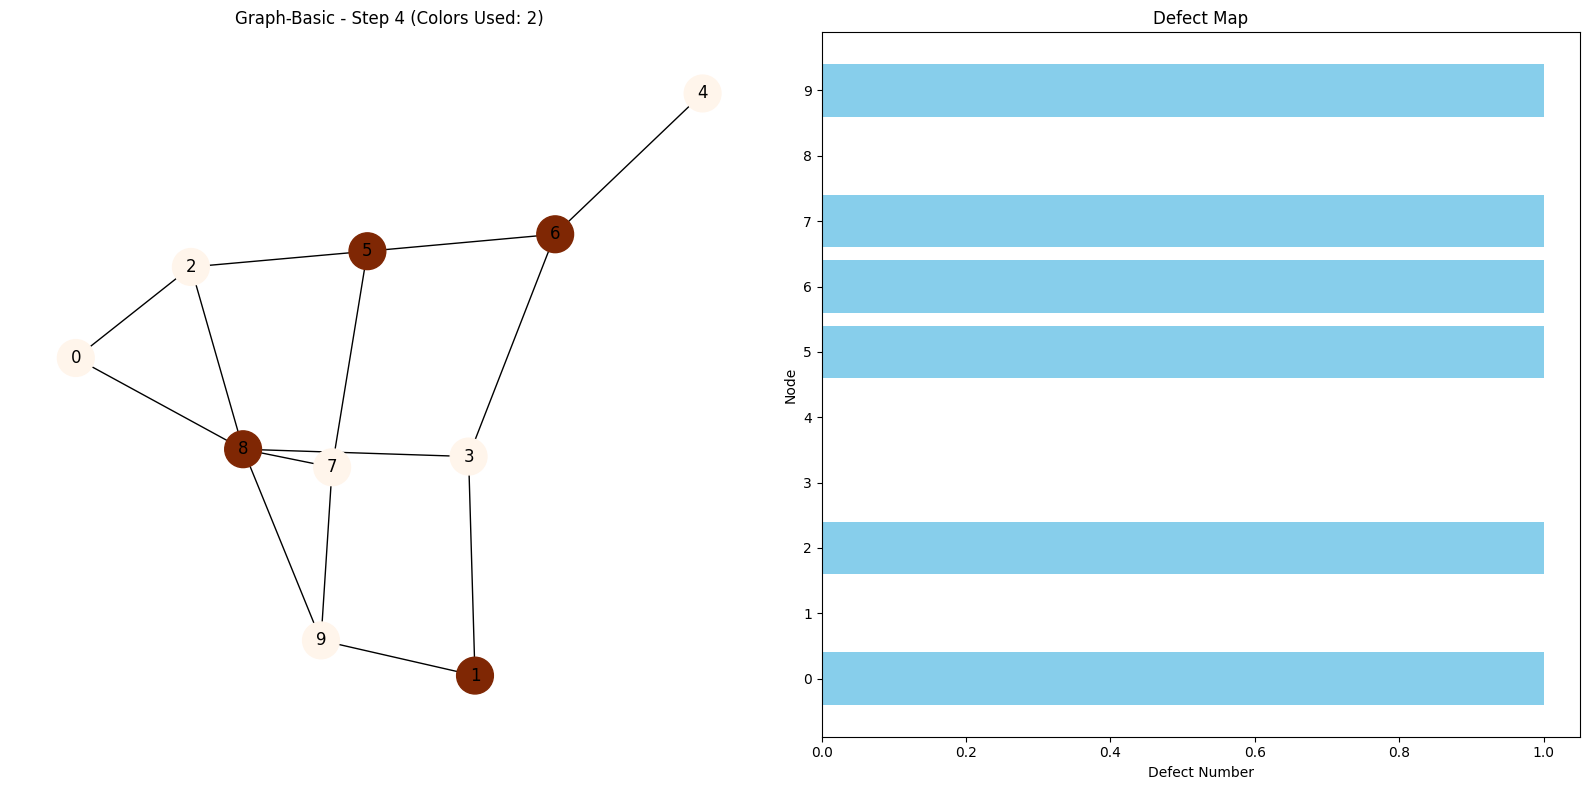

In [237]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

def basic_alg(graph, threshold=1):
    colors = defaultdict(lambda: 0)
    defect_map = {node: len(list(graph.neighbors(node))) for node in graph.nodes()}
    max_defect = max(defect_map.values())

    # Yield initial state for visualization
    yield dict(colors), dict(defect_map), len(set(colors.values()))

    while max_defect > threshold:
        node = max(defect_map, key=defect_map.get)
        old_color = colors[node]
        colors[node] += 1
        new_color = colors[node]

        defect_map[node] = sum(1 for neighbor in graph.neighbors(node) if colors[neighbor] == new_color)

        for neighbor in graph.neighbors(node):
            if colors[neighbor] == old_color:
                defect_map[neighbor] -= 1
            elif colors[neighbor] == new_color:
                defect_map[neighbor] += 1

        max_defect = max(defect_map.values())

        # Yield state after each update for visualization
        yield dict(colors), dict(defect_map), len(set(colors.values()))



# Fix the position of the graph
pos = nx.spring_layout(G, seed=42)  # Fixed layout

# Visualization function
def visualize_graph(G, color_map, defect_map, color_count, step, pos):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Plotting the graph
    ax1.set_title(f"Graph-Basic - Step {step} (Colors Used: {color_count})")
    colors = [color_map.get(node, 0) for node in G.nodes()]
    nx.draw(G, pos, ax=ax1, with_labels=True, node_color=colors, cmap=plt.cm.Oranges, node_size=700)

    # Displaying the defect map
    ax2.set_title("Defect Map")
    ax2.barh(list(defect_map.keys()), list(defect_map.values()), color='skyblue')
    ax2.set_xlabel('Defect Number')
    ax2.set_ylabel('Node')
    ax2.set_yticks(list(defect_map.keys()))
    ax2.set_yticklabels(list(defect_map.keys()))

    plt.tight_layout()
    plt.show()

# Apply the algorithm and visualize each step
for step, (color_map, defect_map, color_count) in enumerate(basic_alg(G)):
    visualize_graph(G, color_map, defect_map, color_count, step, pos)
